In [1]:
# Published at FocalPlane https://focalplane.biologists.com/?p=11702
# Andrey Andreev, Desiderio Ascenio
# California Institute of Technology, David Prober lab
# aandreev@caltech.edu
# 2022

# requirements:
# 'pandas',
# 'matplotlib',
# 'numpy',
# 'skimage.io',

# notebook to load data from segmented cells & activity
# plot activiyt as heatmap and normalized traces
# display locations of cells
# perform clustering

import pandas
import matplotlib

# figures will be generated inside the notebook / web browser
# uncomment for generating figures in individual windows (allows additional features like matplotlib.pyplot.ginput())
# matplotlib.use('TkAgg')

from matplotlib import pyplot as plt
import numpy as np
from skimage import io
from scipy.cluster.vq import vq, kmeans2
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from random import seed

csv_fname = '../data/suite2p_ROI_data_added_columns.csv'
img_fname = '../data/MAX_MAXz_post_bin2x_3sec_350um_range_60Slices_15min_1-z12-1.tif'



In [2]:
data = pandas.read_csv(csv_fname)
# inspect data
# each row represents a single cell
# each column is either a time point, is_cell flag, or X and Y coordinates
data.head(5) # show top 2 rows; use `tail(2)` for bottom 2 rows

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1193,1194,1195,1196,1197,1198,1199,is_cell,x,y
0,0,0,0.000000,0.000000,0.000000,0.071112,0.137652,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,98,30
1,1,0,0.553788,0.294224,0.014636,0.000000,0.000000,0.0,0.000000,0.000000,...,0.002391,0.0,0.045775,0.009973,0.031753,0.028746,0.046584,1,105,129
2,2,0,0.409878,0.407646,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.030472,1,69,73
3,3,0,0.302192,0.379773,0.122698,0.000000,0.000000,0.0,0.000000,0.104660,...,0.000000,0.0,0.008454,0.000000,0.000000,0.060965,0.153083,1,53,95
4,4,0,0.106759,0.000000,0.000000,0.000000,0.147415,0.0,0.025876,0.049277,...,0.000000,0.0,0.000000,0.129580,0.040844,0.204923,0.020806,0,6,78


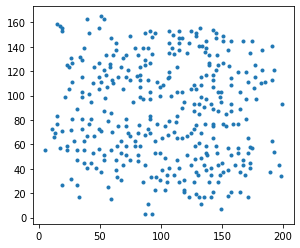

In [3]:
# our data have both "cells" and "not cells" ROIs, diffirentiated by is_cell column
# filter all segemented ROIs by is_cell value
cells = data[data['is_cell'] == 1]

# extract activity columns into separate dataframe
cells_activity = cells.iloc[:, 1:1201]

# extract coordinates of cells:
xs,ys = [cells.x, cells.y]

# plot all locations of cells as points
plt.plot(ys, xs, '.')

# set aspect ratio 1:1
ax = plt.gca()
ax.set_aspect(1)

plt.show()

In [4]:
# function to normalize fluorescence traces
# forces trace to be between 0 and 1
def norm(f):
    return (f - np.min(f))/np.max(f - np.min(f))

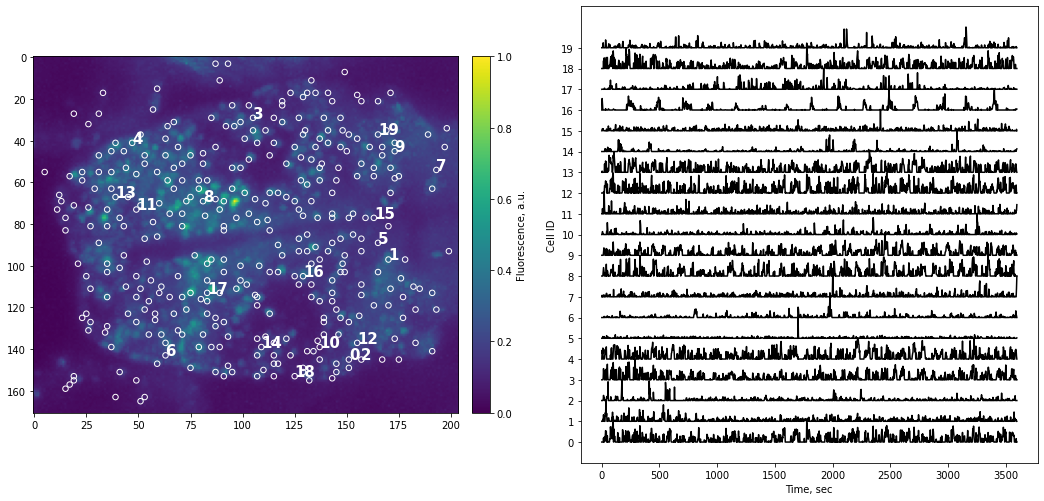

In [5]:
secPerFrame = 3; # time between frames
plt.figure(figsize=(18,10))

# create time axis
ts = np.asarray(range(1200)) * secPerFrame;

ax1 = plt.subplot(1,2,2)
ax2 = plt.subplot(1,2,1)

# show original data image
plt.imshow(io.imread(img_fname))
# plot locations of cells as open circles
plt.scatter(ys, xs, s=30,facecolors='none',edgecolors='w')

# select "first" 20 cells
cell_ids = range(20)

# or select random 20 cells from all the cells, replace=False means that there will be no repetitions
cell_ids = np.random.choice(range(len(cells)), 20, replace=False)

for cell_i in range(len(cell_ids)):
    plt.subplot(1,2,2)
    plt.plot(ts, norm(cells_activity.iloc[cell_ids[cell_i],:]) + cell_i ,'k')
    plt.subplot(1,2,1)
    plt.text(ys.iloc[cell_ids[cell_i]], xs.iloc[cell_ids[cell_i]], cell_i,fontsize=15,color='w',weight='bold')

ax1.set_yticks(range(len(cell_ids)))
ax1.set_ylabel('Cell ID')
ax1.set_xlabel('Time, sec')

ax1.set_aspect(np.max(ts) / len(cell_ids))
ax2.set_aspect(1)

plt.subplot(1,2,1)
cb = plt.colorbar( fraction=0.039, pad=0.03);  # magic numbers fraction & pad to set up proper size of the colorbar
cb.set_label('Fluorescence, a.u.')
plt.show()


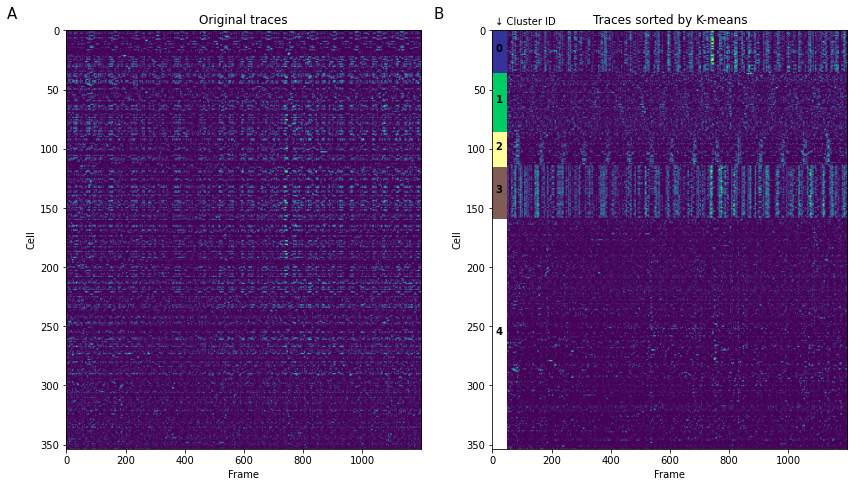

In [29]:
# apply K-means clustering to sort activity traces

# Beware: scykit K-means implements only Euclidian distance metric,
# while MATLAB (for example) also implements correlation metric
# Read more: https://www.mathworks.com/help/stats/kmeans.html#buefs04-Distance

# turn temporal activity data from pandas to numerical type
data_t = np.asarray(cells_activity.iloc[:,:]);

plt.figure(figsize=(14,14))
ax1 = plt.subplot(1,2,1)
plt.imshow(data_t)
ax1.set_aspect(4)
plt.title('Original traces');

ax2 = plt.subplot(1,2,2)

Ks = 5
# K-means relies on random number generation, we can fix the seed to have same result each time 
centroid, labels = kmeans2(data_t, Ks, seed=1111111)

# argsort outputs indeces after sorting the argument
# so i_labels contains indeces of cells, sorted by corresponding cluster ID
i_labels = np.argsort(labels)

plt.imshow(data_t[i_labels,:])
ax2.set_aspect(4)
plt.title('Traces sorted by K-means');

cmap = cm.get_cmap('terrain', Ks)

# Cosmetic code to create a Rectangle patches to label specific K-cluster
Koffset = 0
for Ki in range(Ks):
    Nk = np.size(np.where(labels == Ki))
    # 40 is width of the rectangle
    rect = patches.Rectangle((0, Koffset), 50, Nk, linewidth=1, edgecolor='none', facecolor=cmap(Ki))
    ax2.text( 10, Koffset + Nk/2, Ki ,color='k', weight='bold')
    # Add the patch to the plot
    ax2.add_patch(rect)
    Koffset += Nk

ax2.text(10,-5,'↓ Cluster ID',fontsize=10)

    
# add subplot labels
ax1.text(-200,-10,'A',fontsize=15)
ax2.text(-200,-10,'B',fontsize=15)

ax1.set_xlabel('Frame')
ax2.set_xlabel('Frame')

ax1.set_ylabel('Cell')
ax2.set_ylabel('Cell')




plt.show()

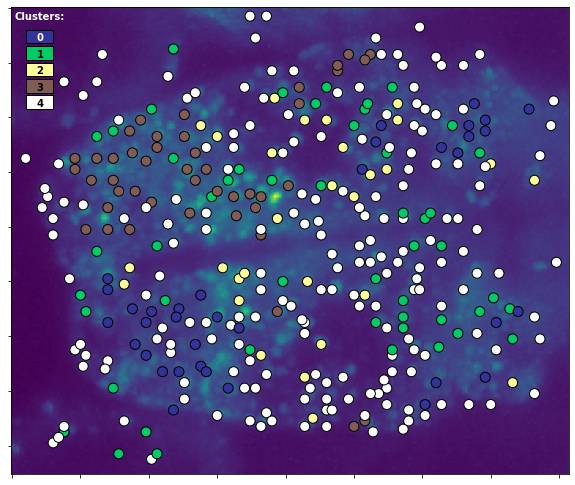

In [7]:
# plot locations of ROIs color-coded by cluster
plt.figure(figsize=(10,10))

# show original data image
# comment it if the image is too busy, but it will require adjusting legend position since imshow flips Y axis
plt.imshow(io.imread(img_fname)) # †

# use same colormap as rectangles from raster plot
# each color represents one cluster
plt.scatter(ys, xs, 100, c = labels, cmap=cmap, edgecolors='k', linewidth=1)

# remove ticks
ax = plt.gca();
ax.set_xticklabels([])
ax.set_yticklabels([])

# add cluster legend
for Ki in range(Ks):
    # create rectangle
    rect = patches.Rectangle((5, Ki*6+8), 10, 5, linewidth=1, edgecolor='k', facecolor=cmap(Ki))
    # add text with cluster number
    ax.text( 5+4, Ki*6+8+4, Ki ,color=('w' if Ki==0 else 'k'), weight='bold')
    # Note: we use white color for cluster 0 due to better visibility
    # see https://en.wikipedia.org/wiki/%3F:#Python for syntax

    # Add the patch to the plot
    ax.add_patch(rect)

# uncomment if you are not using imshow() above (†)
# plt.gca().invert_yaxis()

ax.text(1, 4, 'Clusters:', color='w', weight='bold')
plt.show()

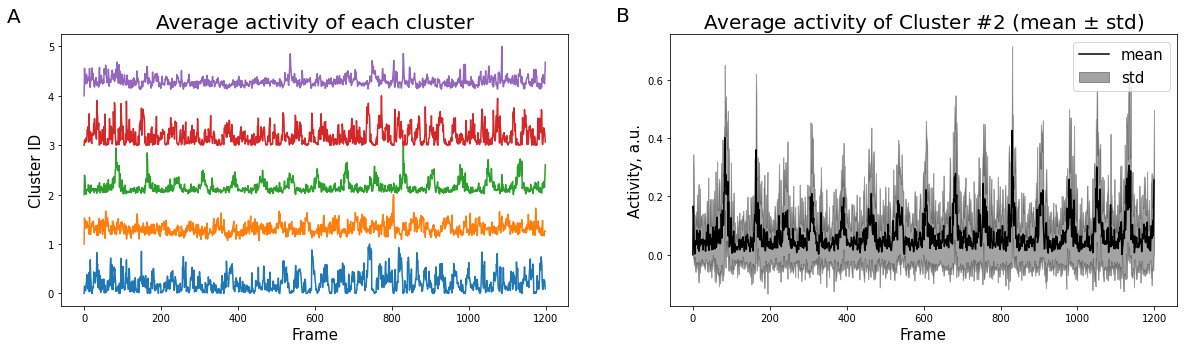

In [8]:
f = plt.figure(figsize=(20,5))
plt.subplot(121)

for Ki in range(0,Ks):
    # find indeces of traces where cluster label equals to Ki
    js = np.where(labels == Ki);
    # calculate average activity trace for cluster Ki
    d  = np.mean(np.squeeze(data_t[js, :]), axis=0);
    # normalize so that each trace is between 0 and 1
    d  = norm(d);
    plt.plot(d+Ki)
    
p = plt.gca();
p.set_ylabel('Cluster ID', fontsize=15)
p.set_xlabel('Frame', fontsize=15)
p.set_title('Average activity of each cluster', fontsize=20)

# add subplot label for figure
plt.text(-200,5.5,'A',fontsize=20)


plt.subplot(122)

K0 = 2;
iis = np.where(labels == K0)[0];
m = np.mean(data_t[iis,:], 0)
s = np.std(data_t[iis,:], 0)
ts = range(0,1200)
plt.plot(m,'-k')
# create fill between mean-std and mean+std, fill with grey color
plt.fill_between(ts, m-s, m+s, alpha=0.4, color=(0.1,0.1,0.1))
p = plt.gca();

# Here we use LaTeX symbol for plus/minus sign
p.set_title('Average activity of Cluster #' +str(K0)+  ' (mean $\pm$ std)', fontsize=20)
p.set_xlabel('Frame', fontsize=15)
p.set_ylabel('Activity, a.u.', fontsize=15)

p.legend(('mean','std'), fontsize=15)
plt.text(-200,0.8,'B',fontsize=20)
plt.show();


In [9]:
from sklearn.manifold import TSNE
# perform t-SNE dimentionality reduction
# t-SNE relies or random number generation, so we fix random_state to have same result each time we run the code
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=1113).fit_transform(data_t)

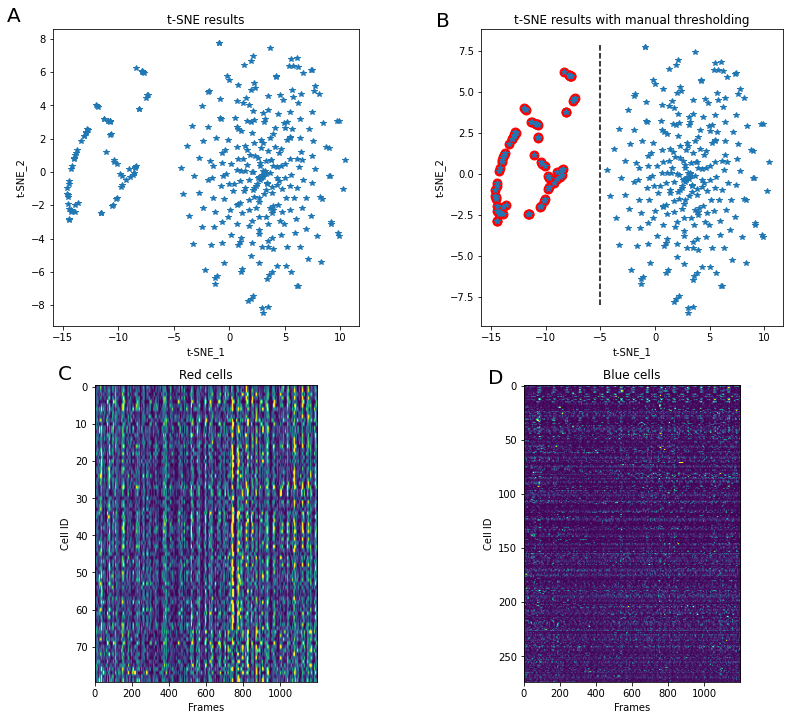

In [28]:
plt.figure(figsize=(14,12))

# plot t-SNE embedding in two-dimentional space
ax_tsne = plt.subplot(221)
plt.plot(X_embedded[:,0], X_embedded[:,1],'*')
plt.text(-20,9,'A',fontsize=20)

# format aspect ratio and axis labels
ax_tsne.set_aspect(1.5)
ax_tsne.set_xlabel('t-SNE_1')
ax_tsne.set_ylabel('t-SNE_2')
ax_tsne.set_title('t-SNE results')

# repeat plotting for further manual thresholding
ax_tsne = plt.subplot(222)
plt.plot(X_embedded[:,0], X_embedded[:,1],'*')
ax_tsne.set_aspect(1.5)
ax_tsne.set_xlabel('t-SNE_1')
ax_tsne.set_ylabel('t-SNE_2')
ax_tsne.set_title('t-SNE results with manual thresholding')
plt.text(-20,9,'B',fontsize=20)


# manually split all elements by tSNE_1 = -5
# np.where returns index of elements that satisfy given condition
iis_red = np.where(X_embedded[:,0]<-5);
iis_blue = np.where(X_embedded[:,0]>=-5);

# label points left to the tSNE_1 = -5 line in red
plt.scatter(X_embedded[iis_red,0], X_embedded[iis_red,1],80, 'r', marker='o')
# demarcation line
plt.plot([-5, -5],[-8, 8],'--k')

# plot traces of all "red" cells
ax1 = plt.subplot(223)
plt.imshow(data_t[np.asarray(iis_red)[0],:], vmin=0,vmax=.50)
ax1.set_aspect(20)
ax1.set_title('Red cells')
ax1.set_ylabel('Cell ID')
ax1.set_xlabel('Frames')
plt.text(-200,-2,'C',fontsize=20)

# plot traces of all "non-red" cells
ax2 = plt.subplot(224)
plt.imshow(data_t[np.asarray(iis_blue)[0],:], vmin=0,vmax=.50)
ax2.set_aspect(6)
ax2.set_title('Blue cells')
ax2.set_ylabel('Cell ID')
ax2.set_xlabel('Frames')
plt.text(-200,-2,'D',fontsize=20)

plt.show()

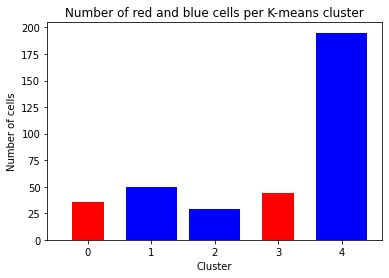

In [11]:
# Compare manual segmentation into red/blue cells and K-means clustering from earlier step
# Plot historgram of cluster values for red cenns and blue cells
plt.hist(labels[iis_blue], bins=range(Ks+1),align='left',rwidth=0.8,facecolor='b')
plt.hist(labels[iis_red],  bins=range(Ks+1),align='left',rwidth=0.5,facecolor='r')
# Red cells are exclusively present in clusters 0 and 3 

ax = plt.gca()
ax.set_title('Number of red and blue cells per K-means cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of cells')

plt.show()

In [12]:
# display all libraries we are using:

import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())


['builtins',
 'builtins',
 'pandas',
 'matplotlib',
 'matplotlib.pyplot',
 'numpy',
 'skimage.io',
 'matplotlib.patches',
 'matplotlib.cm',
 'types']